In [1]:
import datetime
import time
import cirq
import sympy

import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import tensorflow_gan as tfg
from tensorflow.keras import layers

# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
# Data
epochs = 20
batch_size = 100
sample_size = 50
nr_samples = 100

# Load samples
mu = 0
sigma = 1

# Create qubits
num_qubits = 2
qubits = [cirq.GridQubit(x, 0) for x in range(num_qubits)]

In [3]:
def gen_data():
    real_data = np.random.lognormal(mean=mu, sigma=sigma, size=sample_size*nr_samples)
    
    real_data = real_data[real_data < 2 ** num_qubits  - .5]
    real_data = real_data[:len(real_data) // sample_size * sample_size]
    
    data = tf.convert_to_tensor(np.around(real_data, decimals=0), dtype=tf.dtypes.float32)

    batches = tf.reshape(data, (len(real_data) // sample_size, sample_size))

    noise = tfq.convert_to_tensor([cirq.Circuit(
                                    cirq.H.on_each(qubits)) for _ in range(len(real_data))])
    
    return noise, batches

In [4]:
def generator(input_tensor):
    # Qubit parameters
    theta = sympy.symbols(f'a0:{num_qubits}')
    
    # Network Input format
    inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    
    # Replicate Circuit
    param_circuit = cirq.Circuit(cirq.Moment([cirq.ry(t)(q) for t, q in zip(theta, qubits)]))
    entangled_circuit = cirq.Circuit([cirq.CZ(q1, q2) for q1, q2 in zip(qubits[0:-1], qubits[1:])])
    
    circuit = param_circuit + entangled_circuit
    
    readout = sum((cirq.Z(qubits[i]) + 1)/2 * 2 ** i for i in range(num_qubits))
    layer = tfq.layers.PQC(circuit, readout, repetitions=1)(inputs)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[layer])
    
    return tf.cast(tf.reshape(model(input_tensor), (input_tensor.shape[0] // sample_size, sample_size)), dtype=tf.float32)

In [5]:
def discriminator(real_input, fake_input):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(sample_size,)))
    
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model(real_input)

In [6]:
def get_eval_metrics(gan_model):
    real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
    gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)

    cce = tf.keras.losses.CategoricalCrossentropy()
    entropy = cce(gan_model.generated_data, gan_model.real_data)
    
    return {
      'real_data_logits': tf.compat.v1.metrics.mean(real_data_logits),
      'gen_data_logits': tf.compat.v1.metrics.mean(gen_data_logits),
      'entropy':tf.compat.v1.metrics.mean(entropy),
    }

In [7]:
def train(gen_lr, disc_lr):
    # Create the gan object
    gan = tfg.estimator.GANEstimator(
        generator_fn=generator,
        discriminator_fn=discriminator,
        generator_loss_fn=tfg.losses.modified_generator_loss,
        discriminator_loss_fn=tfg.losses.modified_discriminator_loss,
        generator_optimizer=tf.compat.v1.train.AdamOptimizer(gen_lr),
        discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(disc_lr),
        get_eval_metric_ops_fn=get_eval_metrics
    )
    
    steps_eval = 500
    max_train_steps = 5000
    batches_eval = 100
    
    steps = []
    real_logits, fake_logits = [], []
    frequencies = []
    entropy = []
    
    cur_step = 0
    while cur_step < max_train_steps:
        next_step = min(cur_step + steps_eval, max_train_steps)
        gan.train(gen_data, max_steps=next_step)
        steps_taken = next_step - cur_step
        cur_step = next_step
        
        metrics = gan.evaluate(gen_data, steps=batches_eval)
        
        iterator = gan.predict(gen_data)
        predictions = np.array([next(iterator) for _ in range(10)])
    
        frequency = np.mean(
          [np.bincount(p.astype(int), minlength=4) for p in predictions], axis=0)
        print(frequency)
        
        steps.append(cur_step)
        real_logits.append(metrics['real_data_logits'])
        fake_logits.append(metrics['gen_data_logits'])
        
        print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
          real_logits[-1], fake_logits[-1]))
        
        plt.figure()
        plt.bar(np.arange(0,4), frequency)
        
        frequencies.append(frequency)
        entropy.append(metrics['entropy'])
        
    return frequencies, entropy

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdntk3425', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

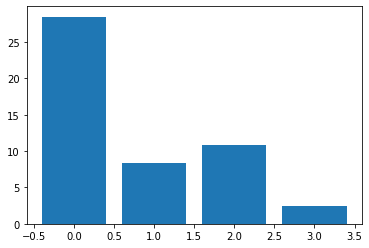

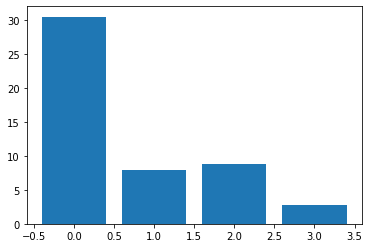

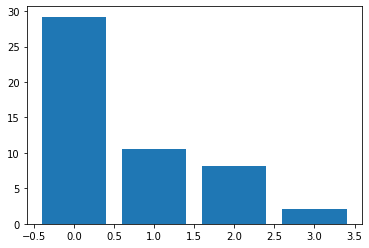

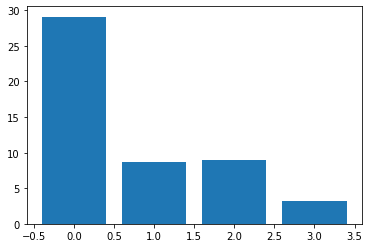

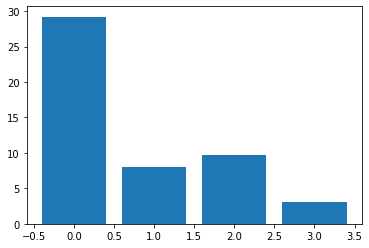

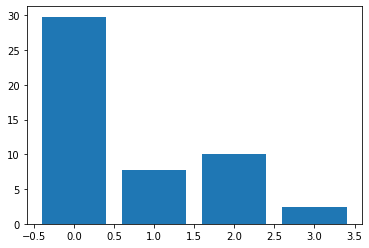

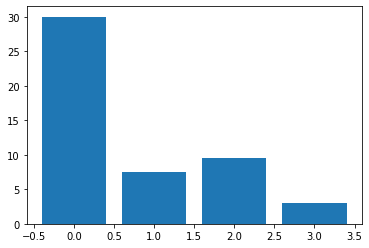

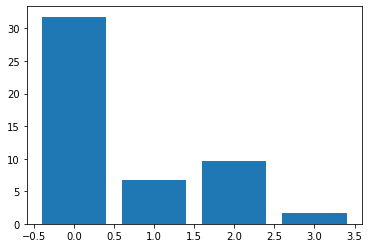

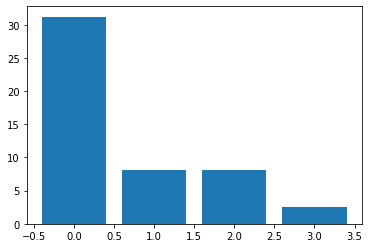

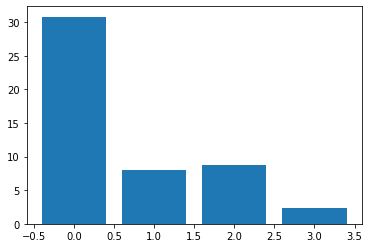

In [8]:
freq, entropy = train(gen_lr=0.001, disc_lr=0.0002)

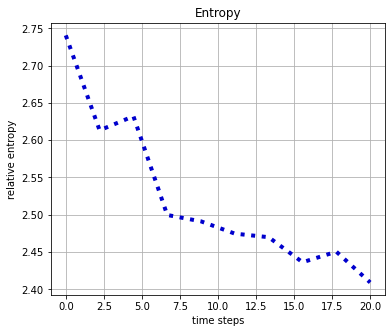

In [9]:
# Plot progress w.r.t relative entropy
entropy = [val/100 for val in entropy]
plt.figure(figsize=(6,5))
plt.title('Entropy')
plt.plot(np.linspace(0, epochs, len(entropy)), entropy, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()